# Decoding mouse from trial syllables

In [2]:
prefix = '/home/ines/repositories/'
# prefix = '/Users/ineslaranjeira/Documents/Repositories/'

In [ ]:
""" 
IMPORTS
"""
import os
import autograd.numpy as np
import seaborn as sns
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
# --Machine learning and statistics
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler,  LabelBinarizer
from sklearn.cluster import KMeans
import random
from sklearn import mixture
import pickle
from scipy.stats import mode
from sklearn.inspection import permutation_importance

# --Machine learning and statistics
from sklearn.model_selection import KFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import f1_score, confusion_matrix
from sklearn.preprocessing import OneHotEncoder
from scipy.stats import entropy

# Get my functions
functions_path =  prefix + 'representation_learning_variability/Functions/'
os.chdir(functions_path)
from data_processing import save_and_log
functions_path =  prefix + 'representation_learning_variability/Models/Sub-trial//2_fit_models/'
os.chdir(functions_path)
from preprocessing_functions import idxs_from_files
functions_path =  prefix + 'representation_learning_variability/Models/Sub-trial//3_postprocess_results/'
os.chdir(functions_path)
from plotting_functions import create_grouped_gradient_palette

from one.api import ONE
one = ONE(mode='remote')

## Parameters

In [4]:
# Parameters
bin_size = 0.017
num_states = 2
threshold = 0.0
optimal_k = 4

save_path = prefix + 'representation_learning_variability/DATA/Sub-trial/Results/'  + str(bin_size) + '/'+str(num_states)+'_states/most_likely_states/'

# LOAD DATA
data_path = prefix + 'representation_learning_variability/DATA/Sub-trial/Design matrix/' + 'v5_15Jan2025/' + str(bin_size) + '/'
all_files = os.listdir(data_path)
design_matrices = [item for item in all_files if 'design_matrix' in item and 'standardized' not in item]
idxs, mouse_names = idxs_from_files(design_matrices, bin_size)

states_path =  prefix + 'representation_learning_variability/DATA/Sub-trial/Results/' + str(bin_size) + '/'+str(num_states)+'_states/most_likely_states/'
wavelet_states_path = prefix + 'representation_learning_variability/DATA/Sub-trial/Results/'  + str(bin_size) + '/wavelet_transform_states/'

path_sets = [wavelet_states_path, states_path, states_path]


# Individual sessions

In [5]:
# Identify sessions available to process
sessions_to_process = []
for m, mat in enumerate(idxs):
    mouse_name = mat[37:]
    session = mat[:36]
    fit_id = str(mouse_name + session)
    whisker_filename = os.path.join(states_path, "most_likely_states" + 'whisker_me' + '_' + fit_id)
    licks_filename = os.path.join(states_path, "most_likely_states" + 'Lick count' + '_' + fit_id)
    wavelet_filename = os.path.join(wavelet_states_path, "most_likely_states_" + str(optimal_k) + '_' + fit_id)

    if os.path.exists(whisker_filename) and os.path.exists(licks_filename) and os.path.exists(wavelet_filename):
        sessions_to_process.append((mouse_name, session))

print(f"Found {len(sessions_to_process)} sessions to process.")

Found 215 sessions to process.


## Get sequences per trial epoch

In [6]:
results_path = prefix + 'representation_learning_variability/Models/Sub-trial/4_analyses/1_HMM_states/'
filename = str(results_path + 'epoch_sequences_10_03-11-2025')
all_sequences = pickle.load(open(filename, 'rb'))

In [118]:
# results_path = prefix + 'representation_learning_variability/Models/Sub-trial/4_analyses/1_HMM_states/'
results_path = prefix + 'representation_learning_variability/paper-individuality/fig1_segmentation/'
# filename = str(results_path + 'epoch_sequences_10_03-11-2025')
filename = str(results_path + 'all_sequences_09-22-2025')
all_sequences = pd.read_parquet(filename)
# all_sequences = pickle.load(open(filename, 'rb'))

In [119]:
design_df = all_sequences.pivot(index=['sample', 'trial_type', 'mouse_name'], columns=['broader_label'], values='binned_sequence').reset_index().dropna()
var_names = design_df.keys()[-4:]

## Get learning speed

In [7]:
data_path = prefix + 'representation_learning_variability/DATA/'
# data_path =  '/Users/ineslaranjeira/Documents/Repositories/representation_learning_variability/DATA/'
learning_df = pd.read_csv(data_path+'learning_private_one.csv')  
learning_times = learning_df[['subject_nickname', 'training_time']].drop_duplicates()
learning_times = learning_times.rename(columns={"subject_nickname": "mouse_name"}).reset_index()

data_path =  prefix + 'representation_learning_variability/DATA/'
learning_df = pd.read_parquet(data_path+'training_time_03-21-2025', engine='pyarrow')
learning_times_new = learning_df.rename(columns={"subject_nickname": "mouse_name"}).reset_index()

# new_df = design_df.droplevel(1, axis=1)[['mouse_name', 'session']]
# df = new_df.merge(learning_times, on='mouse_name')
a = learning_times.merge(learning_times_new, on='mouse_name', how='outer')
b = a.loc[a['training_time_x'].isna()]
b = b.rename(columns={"training_time_y": "training_time"}).reset_index()

full_learning = pd.concat([learning_times[['mouse_name', 'training_time']], b[['mouse_name', 'training_time']]]).reset_index()

/var/folders/nt/d2j3zp9d1xzb8wgfrw81j0c40000gn/T/ipykernel_63622/3750467177.py:3: DtypeWarning: Columns (23) have mixed types. Specify dtype option on import or set low_memory=False.
  learning_df = pd.read_csv(data_path+'learning_private_one.csv')


In [120]:
data_path = prefix + 'representation_learning_variability/paper-individuality/fig3_learning_prediction/'
learning_df_recent = pd.read_parquet(data_path+'training_time_23-09-2025')  

In [121]:
df =design_df.merge(learning_times_new, on=['mouse_name'])
df =design_df.merge(learning_df_recent, on=['mouse_name'])
df['quartile'] = pd.qcut(df['training_time'], q=[0, .25, .5, .75, 1], labels=[1, 2, 3, 4])
# df['quartile'] = pd.qcut(df['training_time'], q=[0, .33, .66, 1], labels=[1, 2, 3])
# df['quartile'] = pd.qcut(df['training_time'], q=[0, .1, .2, .3, .4, .5, .6, .7, .8, .9, 1], 
#                          labels=[1, 2, 3, 4, 5, 6, 7, 8, 9, 10])

## Separate states per variable (one-hot encoding)

In [111]:
epoch_to_analyse = ['Pre-quiescence', 'Quiescence', 'Choice', 'ITI']

sequences_choice = np.vstack(df[epoch_to_analyse].apply(lambda row: np.hstack(row), axis=1))  # Transpose to get the right shape
use_sequences = sequences_choice[~np.isnan(sequences_choice).any(axis=1)]

use_states = int(max(np.unique(use_sequences)))+1
timesteps = np.shape(use_sequences)[1]
binarized = np.zeros((np.shape(use_sequences)[0], timesteps*use_states))

for t in range(timesteps):
    label_binarizer = LabelBinarizer()
    label_binarizer.fit(range(use_states))
    encoded_arr = label_binarizer.transform(use_sequences[:, t])
    binarized[:, t*use_states:(t+1)*use_states] = encoded_arr

### One-hot encoding of trial type

In [11]:
type = pd.factorize(df['trial_type'])[0]
label_binarizer = LabelBinarizer()
label_binarizer.fit(range(len(np.unique(type))))
encoded_arr = label_binarizer.transform(type)

final_matrix = binarized.copy()
final_matrix = np.concatenate((final_matrix, encoded_arr), axis=1)

In [17]:
final_matrix = binarized.copy()

([<matplotlib.axis.XTick at 0x7fc2fb285f00>,
 [Text(0, 0, '0'),
  Text(160, 0, '160'),
  Text(320, 0, '320'),
  Text(480, 0, '480'),
  Text(640, 0, '640'),
  Text(800, 0, '800'),
  Text(960, 0, '960'),
  Text(1120, 0, '1120')])

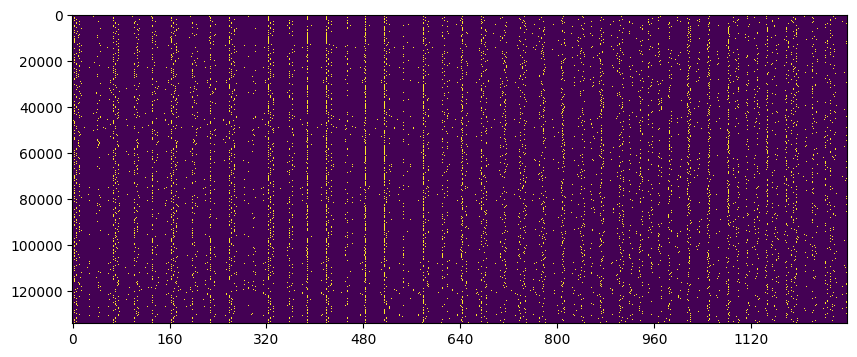

In [18]:
plt.figure(figsize=(10, 4))
plt.imshow(final_matrix, aspect='auto', cmap='viridis', interpolation='none')
plt.xticks(np.arange(0, np.shape(final_matrix)[1], 160), np.arange(0, np.shape(final_matrix)[1], 160))

# Get data of interest for decoder

In [19]:
decoded_var = 'quartile'
var = 'fact_var'

mat = pd.DataFrame(final_matrix)
mat['fact_var'] = pd.factorize(df[decoded_var])[0]
mat[decoded_var] = df[decoded_var]

named_labels = mat[decoded_var].drop_duplicates()
use_mat = mat.drop(columns=[decoded_var])
use_mat = use_mat.sort_values(by='fact_var')


## Decode quartile

In [20]:
def plot_cm(decoding_result, trial_epochs, size, control=False):
    """
    PLOT RESULTS
    """

    # -- Confusion Matrix
    # labels = trial_epochs

    # Results on original model
    plt.rc('font', size=9) 
    plt.figure(figsize=size)
    hmap = sns.color_palette("mako", as_cmap=True)
    data = decoding_result.loc[decoding_result['shuffle'] == 0]
    sns.heatmap(data['confusion_matrix'].mean(), annot=False, square=True,
        yticklabels=trial_epochs, xticklabels=trial_epochs, 
        cmap= hmap, vmin=0, vmax=1, fmt=".2f") 

    # plt.xticks([.5, 1.5, 2.5, 3.5], trial_epochs)
    # plt.yticks([.5, 1.5, 2.5, 3.5], trial_epochs)
    plt.xticks(rotation = 90)
    plt.yticks(rotation = 0)
    plt.xlabel('Predicted label')
    plt.ylabel('True label')
    plt.savefig('full_cm.svg',dpi=500)
    plt.show()
    print('F1 results', data['f1'].mean())

    if control:
        # Results from shuffled model
        plt.rc('font', size=9) 
        plt.figure(figsize=size)
        data = decoding_result.loc[decoding_result['shuffle'] >0]
        sns.heatmap(data['confusion_matrix'].mean(), annot=False, square=True,
            yticklabels=trial_epochs, xticklabels=trial_epochs, 
            cmap= hmap, vmin=0, vmax=1, fmt=".2f")

        # plt.xticks([.5, 1.5, 2.5, 3.5], trial_epochs)
        # plt.yticks([.5, 1.5, 2.5, 3.5], trial_epochs)
        plt.xticks(rotation = 90)
        plt.yticks(rotation = 0)
        plt.xlabel('Predicted label')
        plt.ylabel('True label')
        plt.show()
        print('F1 shuffled results',  data['f1'].mean())
    plt.tight_layout()

def plot_f1(decoding_result):
    # -- F1 score per model, original and shuffled
    data = decoding_result.copy()
    data['f1'] = data['f1'].astype(float)

    data.loc[data['shuffle'] >= 1, 'shuffle'] = 'Shuffled'
    data.loc[data['shuffle'] == 0, 'shuffle'] = 'Original'
    data = data.rename(columns={'shuffle': 'Dataset'})

    plt.rc('font', size=12) 
    plt.figure(figsize=[4.5, 4])
    sns.boxplot(y='f1', x='Dataset', data=data, color='grey') 
    sns.swarmplot(y='f1', x='Dataset', data=data, color='black', dodge=True, alpha=0.7, size=3)
    plt.ylim([0,1])
    plt.ylabel('Accuracy score (F1)')
    plt.legend(bbox_to_anchor=(1.05, 1))
    sns.despine(top=True, right=True)
    #plt.savefig('violin.svg',dpi=500)
    

In [24]:
shufflings = 1  #shuffling
# model = RandomForestClassifier(max_depth=2, random_state=0)
model = RandomForestClassifier(random_state=42)
# model = MultinomialNB()
repeats = 1
splits = 5

In [25]:
"""
RUN MODEL
"""

# Generate random states for each iteration with a fixed seed
# Loop over iterations of random draws of mice
# Create empty dataframes to save results
decoding_result = pd.DataFrame(columns=['shuffle', 'repeat', 'f1', 'confusion_matrix'])
dec_result = pd.DataFrame(columns=['shuffle', 'repeat', 'f1', 'confusion_matrix'])

for r in range(repeats):
    print('Repeat %d of %d' % (r+1, repeats))  
    # Decoding function with 10-fold cross validation
    kf = KFold(n_splits=splits, shuffle=True, random_state=0)
    # use_mat = mat.copy() # test using all mice

    # Find minimum number of samples per label
    labels = np.array(use_mat[var])
    labels_nr = np.arange(len(use_mat[var]))
    min_freq = np.min(use_mat[var].value_counts())
    # min_freq = 400

    # Randomly select N mice from each quartile to equalize classes
    use_index = np.empty(0, dtype=int)
    for j, epoch in enumerate(np.unique(labels)):
        use_index = np.concatenate([use_index, np.random.choice(labels_nr[labels == epoch],
                                                                min_freq, replace=False)])

    new_mat = use_mat.iloc[use_index].reset_index().drop(columns=['index']).copy()
            
    # -- ORIGINAL DATASET
    y_pred = np.zeros(len(new_mat), dtype=int) 
    exog = new_mat[new_mat.columns.difference([var])]
    endog = new_mat.loc[:, var].copy()

    for train_index, test_index in kf.split(new_mat):
        model.fit(exog.iloc[train_index], endog.iloc[train_index].astype(int))
        y_pred[test_index] = model.predict(exog.iloc[test_index])

    # Calculate f1 score and confusion matrix
    f1 = f1_score(endog.astype(int), y_pred.astype('int'), average='micro')
    cm = confusion_matrix(endog.astype(int), y_pred.astype('int'), normalize='true')

    # Save results
    dec_result.loc[0, 'f1'] = f1
    dec_result.loc[0, 'confusion_matrix'] = cm
    dec_result.loc[0, 'shuffle'] = 0
    dec_result.loc[0, 'repeat'] = r

    decoding_result = pd.concat([decoding_result, dec_result])

    # -- SHUFFLED DATASET 
    shuffle_result = pd.DataFrame(columns=['shuffle', 'f1', 'confusion_matrix'])
    for s in range(shufflings):
        if np.mod(s+1, 10) == 0:
            print('Shuffling %d of %d' % (s+1, shufflings))   

        shuffle_y_pred = np.zeros(len(new_mat), dtype=int) 
        shuffle_endog = endog.copy()
        np.random.shuffle(shuffle_endog.values)

        for train_index, test_index in kf.split(new_mat):
            model.fit(exog.iloc[train_index], list(shuffle_endog.iloc[train_index].astype(int)))
            shuffle_y_pred[test_index] = model.predict(exog.iloc[test_index])   

        shuffle_f1 = f1_score(shuffle_endog.astype(int), shuffle_y_pred.astype('int'), average='micro')
        shuffle_cm = confusion_matrix(shuffle_endog.astype(int), shuffle_y_pred.astype('int'), normalize='true')

        # SAVE
        shuffle_result.loc[s, 'f1'] = shuffle_f1
        shuffle_result.loc[s, 'confusion_matrix'] = shuffle_cm
        shuffle_result.loc[s, 'shuffle'] = s + 1

    decoding_result = pd.concat([decoding_result, shuffle_result])

Repeat 1 of 1


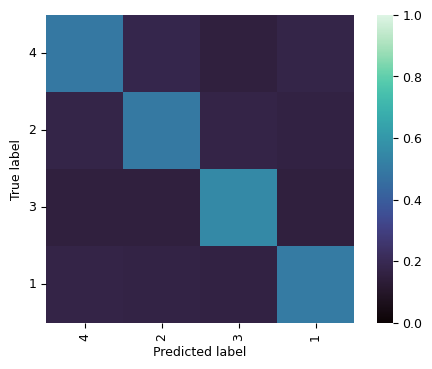

F1 results 0.5108040016183015


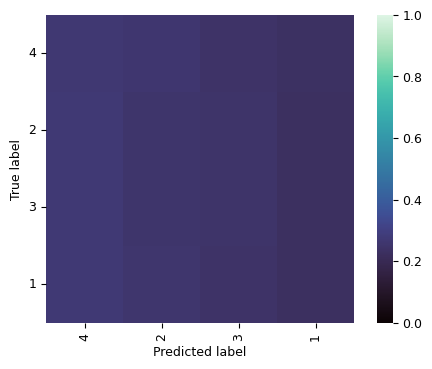

/opt/anaconda3/envs/iblenv/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/anaconda3/envs/iblenv/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/anaconda3/envs/iblenv/lib/python3.10/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored w

F1 shuffled results 0.2489793666556328
0    2.051592
Name: f1, dtype: object


<Figure size 640x480 with 0 Axes>

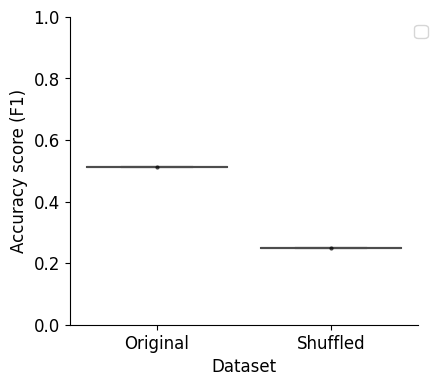

In [26]:
plot_cm(decoding_result, named_labels, [6, 4], control=True)
plot_f1(decoding_result)
decoding_ratio = decoding_result.loc[decoding_result['shuffle']==0, 'f1']/decoding_result.loc[decoding_result['shuffle']==1, 'f1']
print(decoding_ratio)

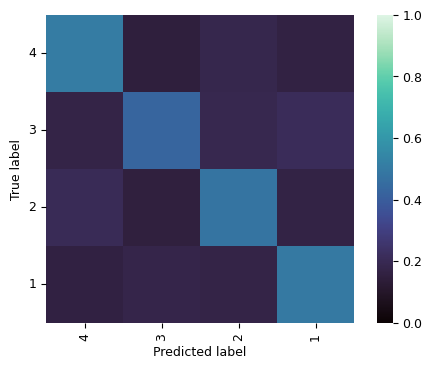

F1 results 0.4763100328129661


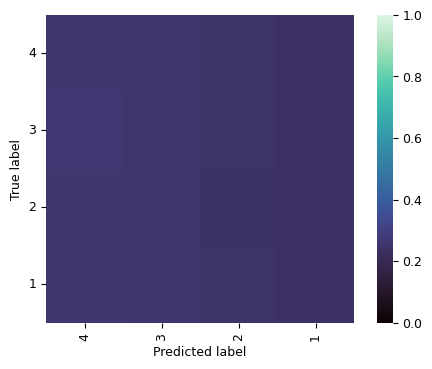

F1 shuffled results 0.24905538430943622
0    1.912466
Name: f1, dtype: object


/tmp/ipykernel_26007/1589584115.py:62: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(bbox_to_anchor=(1.05, 1))


<Figure size 640x480 with 0 Axes>

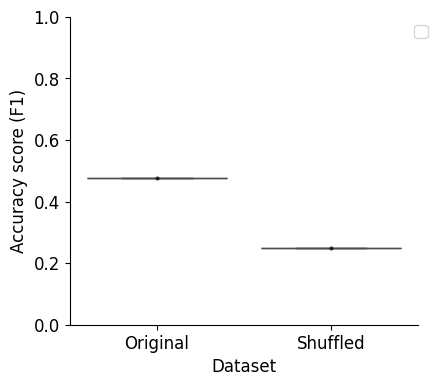

In [41]:
named_labels = mat[decoded_var].drop_duplicates()
plot_cm(decoding_result, named_labels, [6, 4], control=True)
plot_f1(decoding_result)
decoding_ratio = decoding_result.loc[decoding_result['shuffle']==0, 'f1']/decoding_result.loc[decoding_result['shuffle']==1, 'f1']
print(decoding_ratio)

## Compute importances

In [27]:
"""
RUN MODEL
"""

shufflings = 1
splits = 5
# Generate random states for each iteration with a fixed seed
# Loop over iterations of random draws of mice
# Create empty dataframes to save results
decoding_result = pd.DataFrame(columns=['shuffle', 'f1', 'confusion_matrix', 'importances'], index=range(shufflings))

for s in range(shufflings):
    print('Shuffling %d of %d' % (s, shufflings))
    # if np.mod(s+1, 10) == 0:
    #     print('Shuffling %d of %d' % (s+1, shufflings))   
        
    # Decoding function with 10-fold cross validation
    kf = KFold(n_splits=splits, shuffle=True, random_state=0)
    # use_mat = mat.copy() # test using all mice

    # Find minimum number of samples per label
    labels = np.array(use_mat[var])
    labels_nr = np.arange(len(use_mat[var]))
    min_freq = np.min(use_mat[var].value_counts())

    # Randomly select N mice from each quartile to equalize classes
    use_index = np.empty(0, dtype=int)
    for j, epoch in enumerate(np.unique(labels)):
        use_index = np.concatenate([use_index, np.random.choice(labels_nr[labels == epoch],
                                                                min_freq, replace=False)])

    new_mat = use_mat.iloc[use_index].reset_index().drop(columns=['index']).copy()
            
    # -- ORIGINAL DATASET
    dec_result = pd.DataFrame(columns=['shuffle', 'f1', 'confusion_matrix', 'importances'])
    y_pred = np.zeros(len(new_mat), dtype=int) 
    exog = new_mat[new_mat.columns.difference([var])]
    endog = new_mat.loc[:, var].copy()

    iter_importances = np.zeros((splits, np.shape(exog)[1])) * np.nan
    fold = 0
    for train_index, test_index in kf.split(new_mat):
        model.fit(exog.iloc[train_index], endog.iloc[train_index].astype(str))
        y_pred[test_index] = model.predict(exog.iloc[test_index])

        # result = permutation_importance(model, exog.iloc[test_index], y_pred[test_index], 
        #                                 n_repeats=10, random_state=42, n_jobs=2)

        # sorted_importances_idx = result.importances_mean.argsort()
        # importances = pd.DataFrame(
        #     result.importances[sorted_importances_idx].T,
        #     columns=X.columns[sorted_importances_idx],
        # )

        mdi_importances = pd.Series(model[-1].feature_importances_) 
        iter_importances[fold, :] = np.array(mdi_importances)
        fold = fold +1
        
    # Calculate f1 score and confusion matrix
    f1 = f1_score(endog.astype(int), y_pred.astype('int'), average='micro')
    cm = confusion_matrix(endog.astype(int), y_pred.astype('int'), normalize='true')

    # Save results
    dec_result.loc[0, 'f1'] = f1
    dec_result.loc[0, 'confusion_matrix'] = cm
    dec_result.loc[0, 'shuffle'] = s
    dec_result.loc[0, 'importances'] = iter_importances

    decoding_result = pd.concat([decoding_result, dec_result])

Shuffling 0 of 1


In [33]:
use_states = int(max(np.unique(use_sequences)))+1
timesteps = np.shape(use_sequences)[1]
reshaped_importances = np.zeros((use_states, timesteps)) * np.nan
reshaped_importances = pd.DataFrame(columns=['syllable', 'timestep', 'importance', 'repeat'], index=range(use_states * timesteps))

for s in range(shufflings):
       for t in range(timesteps):
              mdi_importances = decoding_result.loc[decoding_result['shuffle']==s, 'importances']
              importances = np.mean(mdi_importances[0], axis=0)
              reshaped_importances['syllable'][t*use_states:(t+1)*use_states] = ['000', '100', '200', '300', '400', '500', '600', '700', '010', '110',
                     '210', '310', '410', '510', '610', '710', '001', '101', '201', '301', '401', '501', '601', '701', '011',
                     '111', '211', '311', '411', '511',  '611',  '711']
              reshaped_importances['timestep'][t*use_states:(t+1)*use_states] = t
              reshaped_importances['importance'][t*use_states:(t+1)*use_states] = importances[t*use_states:(t+1)*use_states]
              reshaped_importances['repeat'][t*use_states:(t+1)*use_states] = s

/var/folders/nt/d2j3zp9d1xzb8wgfrw81j0c40000gn/T/ipykernel_63622/1574201220.py:10: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  reshaped_importances['syllable'][t*use_states:(t+1)*use_states] = ['000', '100', '200', '300', '400', '500', '60

In [37]:
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib.colors import ListedColormap, to_rgb, to_hex

def create_grouped_gradient_palette(n_groups=4, shades_per_group=4, base_palette='Set1'):
    # Pick n_groups distinct colors from base palette
    base_colors = sns.color_palette(base_palette, n_colors=n_groups)
    
    # Function to generate shades for a given color
    def generate_shades(color, n_shades):
        color_rgb = np.array(to_rgb(color))
        # Create shades by interpolating towards white (lighter) or black (darker)
        factors = np.linspace(0.4, 1.0, n_shades)  # You can adjust range for more/less contrast
        return [to_hex(color_rgb * factor + (1 - factor)) for factor in factors]
    
    # Build full palette
    full_palette = []
    for color in base_colors:
        shades = generate_shades(color, shades_per_group)
        full_palette.extend(shades)
    
    return ListedColormap(full_palette)

In [124]:
# 8 + 1 + 1
whisker_mapping = {0.0:0.0,
           1.0:0.0,
           2.0:0.0,
           3.0:0.0,
           4.0:0.0,
           5.0:0.0,
           6.0:0.0,
           7.0:0.0,
           
           8.0:1.0,
           9.0:1.0,
           10.0:1.0,
           11.0:1.0,
           12.0:1.0,
           13.0:1.0,
           14.0:1.0,
           15.0:1.0,

           16.0:0.0,
           17.0:0.0,
           18.0:0.0,
           19.0:0.0, 
           20.0:0.0, 
           21.0:0.0, 
           22.0:0.0, 
           23.0:0.0, 

           24.0:1.0,
           25.0:1.0,
           26.0:1.0,
           27.0:1.0,
           28.0:1.0,
           29.0:1.0,
           30.0:1.0,
           31.0:1.0,
           }
licking_mapping = {0.0:0.0,
           1.0:0.0,
           2.0:0.0,
           3.0:0.0,
           4.0:0.0,
           5.0:0.0,
           6.0:0.0,
           7.0:0.0,
           
           8.0:0.0,
           9.0:0.0,
           10.0:0.0,
           11.0:0.0,
           12.0:0.0,
           13.0:0.0,
           14.0:0.0,
           15.0:0.0,

           16.0:1.0,
           17.0:1.0,
           18.0:1.0,
           19.0:1.0, 
           20.0:1.0, 
           21.0:1.0, 
           22.0:1.0, 
           23.0:0.0, 

           24.0:1.0,
           25.0:1.0,
           26.0:1.0,
           27.0:1.0,
           28.0:1.0,
           29.0:1.0,
           30.0:1.0,
           31.0:1.0,
           }
paw_mapping = {0.0:0.0,
           1.0:1.0,
           2.0:2.0,
           3.0:3.0,
           4.0:4.0,
           5.0:5.0,
           6.0:6.0,
           7.0:7.0,
           
           8.0:1.0,
           9.0:2.0,
           10.0:3.0,
           11.0:4.0,
           12.0:5.0,
           13.0:6.0,
           14.0:7.0,
           15.0:8.0,

           16.0:1.0,
           17.0:2.0,
           18.0:3.0,
           19.0:4.0, 
           20.0:5.0, 
           21.0:6.0, 
           22.0:7.0, 
           23.0:8.0, 

           24.0:1.0,
           25.0:2.0,
           26.0:3.0,
           27.0:4.0,
           28.0:5.0,
           29.0:6.0,
           30.0:7.0,
           31.0:8.0,
           }

whisker_func = np.vectorize(whisker_mapping.get)
licking_func = np.vectorize(licking_mapping.get)
paw_func = np.vectorize(paw_mapping.get)

whisker_sequences = whisker_func(use_sequences)
licking_sequences = licking_func(use_sequences)
paw_sequences = paw_func(use_sequences)

identifiable_mapping = {'000': 0.0,
           '100': 1.0,
           '200': 2.0,
           '300': 3.0,
           '400': 4.0,
           '500': 5.0,
           '600': 6.0,
           '700': 7.0,
           
           '010': 8.0,
           '110': 9.0,
           '210': 10.0,
           '310': 11.0,
           '410': 12.0,
           '510': 13.0,
           '610': 14.0,
           '710': 15.0,

           '001': 16.0,
           '101': 17.0,
           '201': 18.0,
           '301': 19.0, 
           '401': 20.0, 
           '501': 21.0, 
           '601': 22.0, 
           '701': 23.0, 

           '011': 24.0,
           '111': 25.0,
           '211': 26.0,
           '311': 27.0,
           '411': 28.0,
           '511': 29.0,
           '611': 30.0,
           '711': 31.0,
           'nan': np.nan
           }

inverted_mapping = {v: k for k, v in identifiable_mapping.items()}
invert_func = np.vectorize(inverted_mapping.get)

/opt/anaconda3/envs/iblenv/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/anaconda3/envs/iblenv/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/anaconda3/envs/iblenv/lib/python3.10/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/opt/anaconda3/envs/iblenv/lib/python3.10/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with 

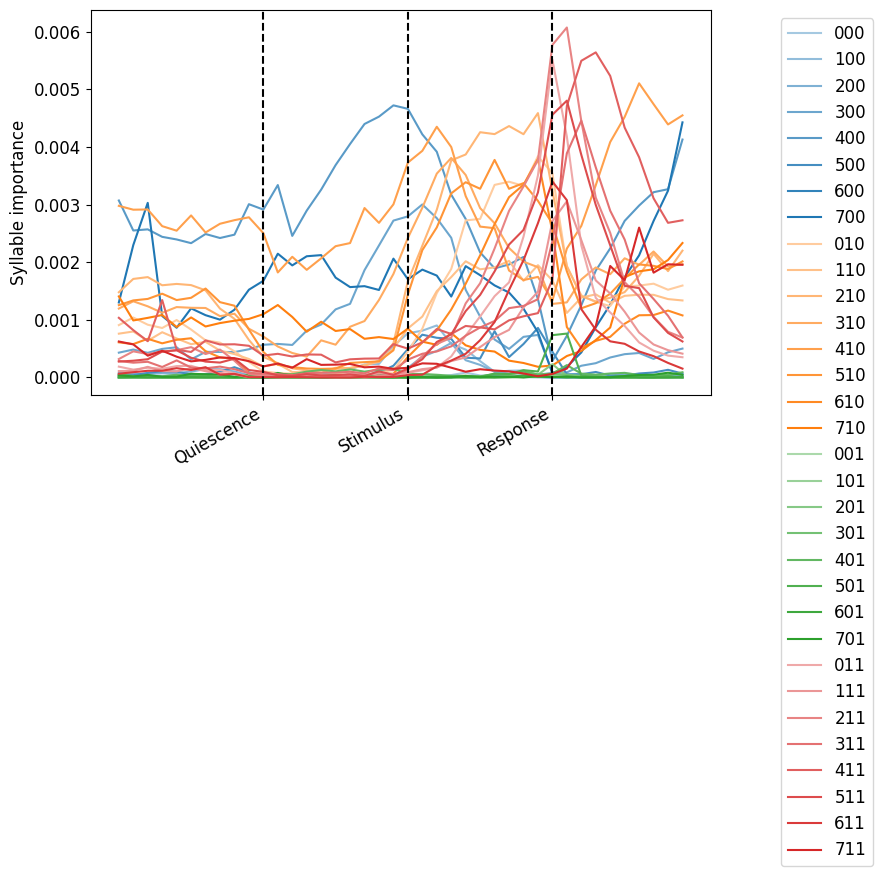

In [125]:
palette_16 = create_grouped_gradient_palette(n_groups=4, shades_per_group=8, base_palette='tab10')
palette_16_list = [palette_16(i) for i in range(palette_16.N)]  # Extract colors properly
order = ['000', '100', '200', '300', '010', '110',
           '210', '310', '001', '101', '201', '301', '011',
           '111', '211', '311']
wheel = ['000', '100', '200', '300', '400', '500', '600', '700', '010', '110',
                     '210', '310', '410', '510', '610', '710', '001', '101', '201', '301', '401', '501', '601', '701', '011',
                     '111', '211', '311', '411', '511',  '611',  '711']

state_to_color = dict(zip(order, palette_16_list))

fig, axs = plt.subplots(1, 1, sharex=True, sharey=True, figsize=(8, 5))

sns.lineplot(x='timestep', y='importance', hue='syllable', data=reshaped_importances, 
             ax=axs, palette=palette_16_list)
axs.axvline(x=10, color='k', linestyle='--')
axs.axvline(x=20, color='k', linestyle='--')
axs.axvline(x=30, color='k', linestyle='--')
axs.legend(loc='upper left', bbox_to_anchor=(1.1, 1))
axs.set_ylabel('Syllable importance')
axs.set_xlabel('')
axs.set_xticks(np.arange(10, 31, 10), ['Quiescence', 'Stimulus', 'Response'], rotation=30, ha='right')


In [92]:
def mask_syllables_with_state(matrix, letter, pos):
    # Boolean mask
    mask = np.vectorize(lambda w: len(w) > pos and w[pos] == letter)(matrix)
    # Fill unmatched with empty string (or np.nan if you prefer)
    new_matrix = np.ones(np.shape(matrix))
    result = np.where(mask, new_matrix, 0)
    # result = np.where(mask, matrix)
    return result

In [114]:
color

[(0.8941176470588236, 0.10196078431372549, 0.10980392156862745),
 (0.21568627450980393, 0.49411764705882355, 0.7215686274509804),
 (0.30196078431372547, 0.6862745098039216, 0.2901960784313726),
 (0.596078431372549, 0.3058823529411765, 0.6392156862745098),
 (1.0, 0.4980392156862745, 0.0),
 (1.0, 1.0, 0.2),
 (0.6509803921568628, 0.33725490196078434, 0.1568627450980392),
 (0.9686274509803922, 0.5058823529411764, 0.7490196078431373)]

0 1
1 2


/var/folders/nt/d2j3zp9d1xzb8wgfrw81j0c40000gn/T/ipykernel_63622/28005301.py:34: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


2 3


/var/folders/nt/d2j3zp9d1xzb8wgfrw81j0c40000gn/T/ipykernel_63622/28005301.py:34: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


3 4


/var/folders/nt/d2j3zp9d1xzb8wgfrw81j0c40000gn/T/ipykernel_63622/28005301.py:34: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


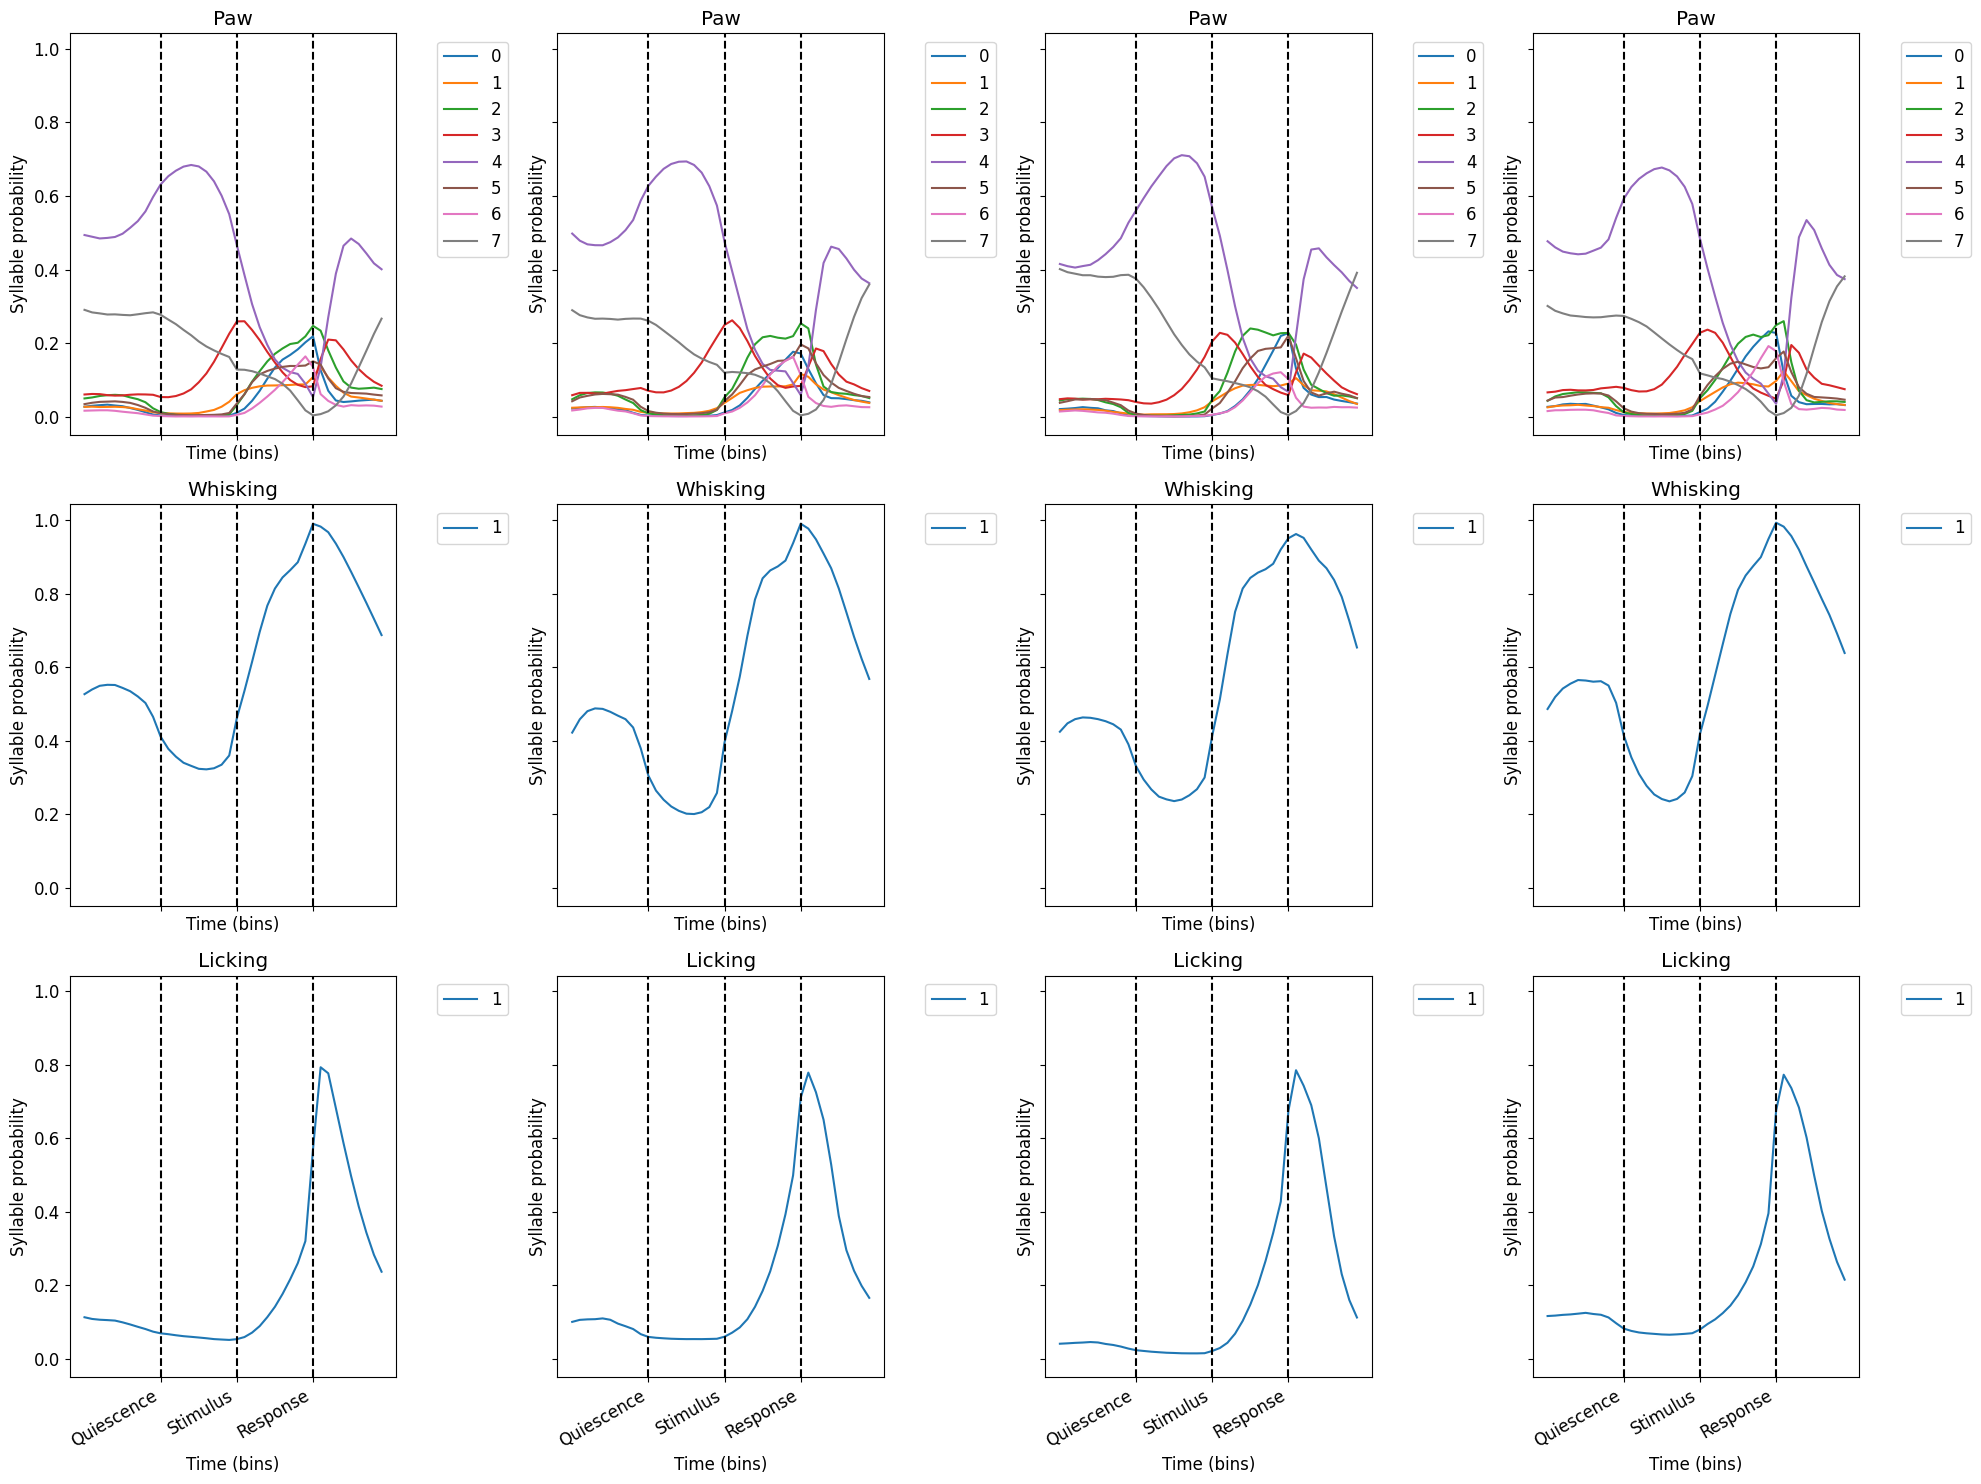

In [126]:
trials = pd.DataFrame(use_sequences)
trials['mouse_name'] = df['mouse_name']
trials['mouse_number'] = pd.factorize(df['mouse_name'])[0]
trials['quartile'] = df['quartile']

epoch_to_analyse = ['Pre-quiescence', 'Quiescence', 'Choice', 'ITI']

color = sns.color_palette("Set1", 8)
fig, axs = plt.subplots(3, np.max(df.quartile), sharex=True, sharey=True, figsize=(20, 15))

for q, quartile in enumerate(np.arange(1, np.max(df.quartile)+1)):
    print(q, quartile)
    quartile_data = trials.loc[trials['quartile']==quartile]
    quartile_sequences = np.array(quartile_data.drop(columns=['mouse_name', 'mouse_number', 'quartile']))
    syllables = invert_func(quartile_sequences)
    titles = ['Paw', 'Whisking', 'Licking']
    unique_syllables = [['0', '1', '2', '3', '4', '5', '6', '7'], ['0', '1'], ['0', '1']]
    for i in range(3):
        unique_syllable_digits = unique_syllables[i]
        for u in unique_syllable_digits:
            if len(unique_syllable_digits)==2 and u == '0':
                continue
            syllable_interest = mask_syllables_with_state(syllables, u, i)
            syllable_interest = np.nanmean(syllable_interest, axis=0)
            axs[i, q].plot(np.arange(0, 40,1), syllable_interest, label=u) # , color=color[u], label=str(u)
        axs[i, q].set_title(titles[i])
        axs[i, q].set_xlabel('Time (bins)')
        axs[i, q].set_ylabel('Syllable probability')
        axs[i, q].axvline(x=10, color='k', linestyle='--')
        axs[i, q].axvline(x=20, color='k', linestyle='--')
        axs[i, q].axvline(x=30, color='k', linestyle='--')
        axs[i, q].legend(loc='upper left', bbox_to_anchor=(1.1, 1))
        axs[i, q].set_xticks(np.arange(10, 31, 10), ['Quiescence', 'Stimulus', 'Response'], rotation=30, ha='right')
    plt.tight_layout()

/var/folders/nt/d2j3zp9d1xzb8wgfrw81j0c40000gn/T/ipykernel_63622/1247383163.py:14: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.lineplot(x='timestep', y='importance', data=importances_syllable,
/opt/anaconda3/envs/iblenv/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/anaconda3/envs/iblenv/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/var/folders/nt/d2j3zp9d1xzb8wgfrw81j0c40000gn/T/ipykernel_63622/1247383163.py:14: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.lineplot(x='timestep', y='importance', data=

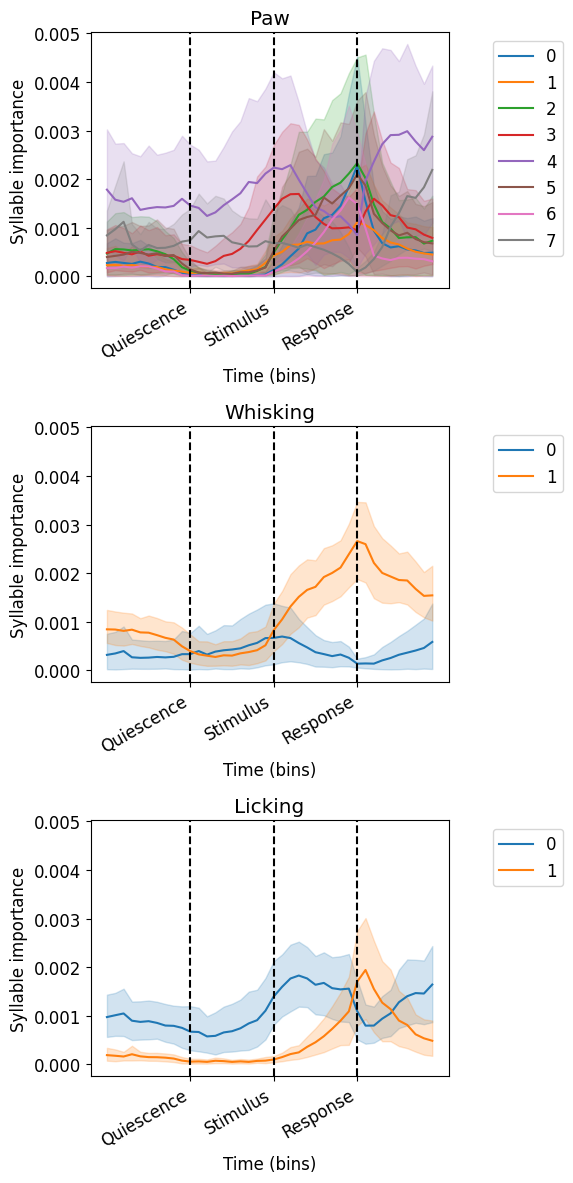

In [ ]:
epoch_to_analyse = ['Pre-quiescence', 'Quiescence', 'Choice', 'ITI']

color = sns.color_palette("Set1", 8)
fig, axs = plt.subplots(3, 1, sharex=False, sharey=True, figsize=(6, 12))
syllables = np.array([[int(d) for d in s] for s in reshaped_importances['syllable']])
titles = ['Paw', 'Whisking', 'Licking']
for i in range(3):
    unique_syllable_digits = np.unique(syllables[:, i])
    for u in unique_syllable_digits:
        if len(unique_syllable_digits)==2 & u == 0:
            continue
        syllable_interest = np.where(syllables[:, i]==u)
        importances_syllable = reshaped_importances.loc[syllable_interest]
        sns.lineplot(x='timestep', y='importance', data=importances_syllable, 
             ax=axs[i], palette=color[u], label=str(u))
    axs[i].set_title(titles[i])
    axs[i].set_xlabel('Time (bins)')
    axs[i].set_ylabel('Syllable importance')
    axs[i].axvline(x=10, color='k', linestyle='--')
    axs[i].axvline(x=20, color='k', linestyle='--')
    axs[i].axvline(x=30, color='k', linestyle='--')
    axs[i].legend(loc='upper left', bbox_to_anchor=(1.1, 1))
    axs[i].set_xticks(np.arange(10, 31, 10), ['Quiescence', 'Stimulus', 'Response'], rotation=30, ha='right')
plt.tight_layout()

# Visualize clusters

In [19]:
wheel_0_mapping = {0:0, 1:1, 2:0, 3:0,
                 4:0, 5:1, 6:0, 7:0,
                 8:0, 9:1, 10:0, 11:0,
                 12:0, 13:1, 14:0, 15:0}
wheel_1_mapping = {0:0, 1:0, 2:1, 3:0,
                 4:0, 5:0, 6:1, 7:0,
                 8:0, 9:0, 10:1, 11:0,
                 12:0, 13:0, 14:1, 15:0}
wheel_2_mapping = {0:0, 1:0, 2:0, 3:0,
                 4:0, 5:0, 6:0, 7:1,
                 8:0, 9:0, 10:0, 11:1,
                 12:0, 13:0, 14:0, 15:1}
wheel_3_mapping = {0:1, 1:0, 2:0, 3:0,
                 4:1, 5:0, 6:0, 7:0,
                 8:1, 9:0, 10:0, 11:0,
                 12:1, 13:0, 14:0, 15:0}
whisker_mapping = {0:0, 1:0, 2:0, 3:0,
                 4:1, 5:1, 6:1, 7:1,
                 8:0, 9:0, 10:0, 11:0,
                 12:1, 13:1, 14:1, 15:1}
lick_mapping = {0:0, 1:0, 2:0, 3:0,
                 4:0, 5:0, 6:0, 7:0,
                 8:1, 9:1, 10:1, 11:1,
                 12:1, 13:1, 14:1, 15:1}


In [ ]:
wheel_0_mapping = {0:0, 1:1, 2:0, 3:0,
                 4:0, 5:1, 6:0, 7:0,
                 8:0, 9:1, 10:0, 11:0,
                 12:0, 13:1, 14:0, 15:0}
wheel_1_mapping = {0:0, 1:0, 2:1, 3:0,
                 4:0, 5:0, 6:1, 7:0,
                 8:0, 9:0, 10:1, 11:0,
                 12:0, 13:0, 14:1, 15:0}
wheel_2_mapping = {0:0, 1:0, 2:0, 3:0,
                 4:0, 5:0, 6:0, 7:1,
                 8:0, 9:0, 10:0, 11:1,
                 12:0, 13:0, 14:0, 15:1}
wheel_3_mapping = {0:1, 1:0, 2:0, 3:0,
                 4:1, 5:0, 6:0, 7:0,
                 8:1, 9:0, 10:0, 11:0,
                 12:1, 13:0, 14:0, 15:0}
whisker_mapping = {0:0, 1:0, 2:0, 3:0,
                 4:1, 5:1, 6:1, 7:1,
                 8:0, 9:0, 10:0, 11:0,
                 12:1, 13:1, 14:1, 15:1}
lick_mapping = {0:0, 1:0, 2:0, 3:0,
                 4:0, 5:0, 6:0, 7:0,
                 8:1, 9:1, 10:1, 11:1,
                 12:1, 13:1, 14:1, 15:1}

## With error bars

In [31]:
trials = pd.DataFrame(use_sequences)
trials['mouse_name'] = df['mouse_name']
trials['mouse_number'] = pd.factorize(df['mouse_name'])[0]
trials['quartile'] = df['quartile']

0 1
1 2
2 3
3 4


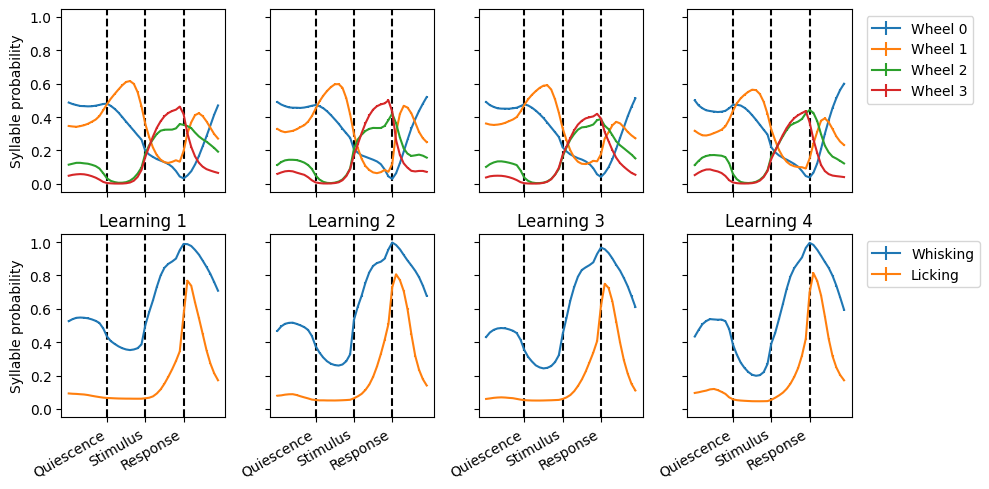

In [47]:
epoch_to_analyse = ['Pre-quiescence', 'Quiescence', 'Choice', 'ITI']

color = sns.color_palette("Set2", 7)
fig, axs = plt.subplots(2, np.max(df.quartile), sharex=True, sharey=True, figsize=(10, 5))

for q, quartile in enumerate(np.arange(1, np.max(df.quartile)+1)):
    print(q, quartile)
    quartile_data = trials.loc[trials['quartile']==quartile]
    use_sequences = np.array(quartile_data.drop(columns=['mouse_name', 'mouse_number', 'quartile']))

    replace_whisker = np.vectorize(whisker_mapping.get)
    whisker_states = replace_whisker(use_sequences)
    replace_wheel_0 = np.vectorize(wheel_0_mapping.get)
    replace_wheel_1 = np.vectorize(wheel_1_mapping.get)
    replace_wheel_2 = np.vectorize(wheel_2_mapping.get)
    replace_wheel_3 = np.vectorize(wheel_3_mapping.get)
    wheel_state_0 = replace_wheel_0(use_sequences)    
    wheel_state_1 = replace_wheel_1(use_sequences)    
    wheel_state_2 = replace_wheel_2(use_sequences)    
    wheel_state_3 = replace_wheel_3(use_sequences)    
    replace_lick = np.vectorize(lick_mapping.get)
    lick_states = replace_lick(use_sequences)
    
    
    # Mean
    whisker_count = np.mean(whisker_states, axis=0)
    lick_count = np.mean(lick_states, axis=0)
    wheel_count_0 = np.mean(wheel_state_0, axis=0)
    wheel_count_1 = np.mean(wheel_state_1, axis=0)
    wheel_count_2 = np.mean(wheel_state_2, axis=0)
    wheel_count_3 = np.mean(wheel_state_3, axis=0)
        
    all_stacked = np.vstack([wheel_count_0, wheel_count_1, wheel_count_2, wheel_count_3,
                             whisker_count, lick_count])

    # Error
    whisker_error = np.std(whisker_states, axis=0)/np.sqrt(np.shape(whisker_states)[0])*1.96
    lick_error = np.std(lick_states, axis=0)/np.sqrt(np.shape(whisker_states)[0])*1.96
    wheel_error_0 = np.std(wheel_state_0, axis=0)/np.sqrt(np.shape(whisker_states)[0])*1.96
    wheel_error_1 = np.std(wheel_state_1, axis=0)/np.sqrt(np.shape(whisker_states)[0])*1.96
    wheel_error_2 = np.std(wheel_state_2, axis=0)/np.sqrt(np.shape(whisker_states)[0])*1.96
    wheel_error_3 = np.std(wheel_state_3, axis=0)/np.sqrt(np.shape(whisker_states)[0])*1.96
        
    all_error_stacked = np.vstack([wheel_error_0, wheel_error_1, wheel_error_2, wheel_error_3, 
                                   whisker_error, lick_error])
    
    axs[0, q].errorbar(np.arange(0, 40, 1), all_stacked[0:1, :][0], yerr=all_error_stacked[0:1, :][0], label='Wheel 0')
    axs[0, q].errorbar(np.arange(0, 40, 1), all_stacked[1:2, :][0], yerr=all_error_stacked[1:2, :][0], label='Wheel 1')
    axs[0, q].errorbar(np.arange(0, 40, 1), all_stacked[2:3, :][0], yerr=all_error_stacked[2:3, :][0], label='Wheel 2')
    axs[0, q].errorbar(np.arange(0, 40, 1), all_stacked[3:4, :][0], yerr=all_error_stacked[3:4, :][0], label='Wheel 3')
      
    axs[1, q].errorbar(np.arange(0, 40, 1), all_stacked[4:5, :][0], yerr=all_error_stacked[4:5, :][0], label='Whisking')
    axs[1, q].errorbar(np.arange(0, 40, 1), all_stacked[5:6, :][0], yerr=all_error_stacked[5:6, :][0], label='Licking')

    axs[0, q].axvline(x=10, color='k', linestyle='--')
    axs[0, q].axvline(x=20, color='k', linestyle='--')
    axs[0, q].axvline(x=30, color='k', linestyle='--')
    axs[1, q].axvline(x=10, color='k', linestyle='--')
    axs[1, q].axvline(x=20, color='k', linestyle='--')
    axs[1, q].axvline(x=30, color='k', linestyle='--')

    axs[1, q].set_xticks(np.arange(10, 31, 10), ['Quiescence', 'Stimulus', 'Response'], rotation=30, ha='right')
    axs[1, q].set_title('Learning ' +str(quartile))
axs[0, q].legend(bbox_to_anchor=(1.05, 1.0), loc='upper left')
axs[1, q].legend(bbox_to_anchor=(1.05, 1.0), loc='upper left')
axs[0, 0].set_ylabel('Syllable probability')
axs[1, 0].set_ylabel('Syllable probability')
plt.tight_layout()
plt.show()


## Vizualize results

In [216]:
wheel_mapping = {0:0, 1:1, 2:2, 3:3,
                 4:0, 5:1, 6:2, 7:3,
                 8:0, 9:1, 10:2, 11:3,
                 12:0, 13:1, 14:2, 15:3}
whisker_mapping = {0:0, 1:0, 2:0, 3:0,
                 4:1, 5:1, 6:1, 7:1,
                 8:0, 9:0, 10:0, 11:0,
                 12:1, 13:1, 14:1, 15:1}
lick_mapping = {0:0, 1:0, 2:0, 3:0,
                 4:0, 5:0, 6:0, 7:0,
                 8:1, 9:1, 10:1, 11:1,
                 12:1, 13:1, 14:1, 15:1}
replace_wheel = np.vectorize(wheel_mapping.get)
# wheel_states = replace_wheel(use_sequences)
replace_whisker = np.vectorize(whisker_mapping.get)
# whisker_states = replace_whisker(use_sequences)
replace_lick = np.vectorize(lick_mapping.get)

In [ ]:
# select mice with very good decoding or bad

/tmp/ipykernel_19502/2601245174.py:51: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(bbox_to_anchor=(1.05, 1.0), loc='upper left')


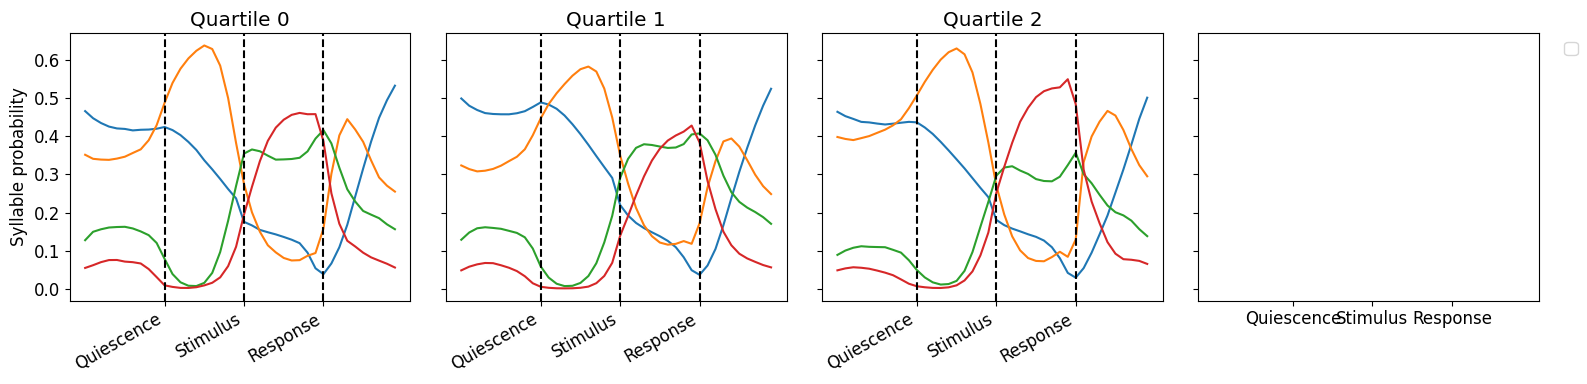

In [217]:
epoch_to_analyse = ['Pre-quiescence', 'Quiescence', 'Choice', 'ITI']

color = sns.color_palette("Set2", 7)
fig, axs = plt.subplots(1, 4, sharex=True, sharey=True, figsize=(16, 4))

use_data = trial_clusters.merge(entropy_df[['mouse_name', 'accuracy_type']].drop_duplicates(), on=['mouse_name'])


for q, quartile in enumerate([0, 1, 2]):
    cluster_data = use_data.loc[use_data['accuracy_type']==quartile]
    sequences_choice = np.vstack(cluster_data[epoch_to_analyse].apply(lambda row: np.hstack(row), axis=1))  # Transpose to get the right shape
    use_sequences = sequences_choice[~np.isnan(sequences_choice).any(axis=1)]
    
    replace_whisker = np.vectorize(whisker_mapping.get)
    whisker_states = replace_whisker(use_sequences)
    replace_wheel = np.vectorize(wheel_mapping.get)
    wheel_states = replace_wheel(use_sequences)    
    replace_lick = np.vectorize(lick_mapping.get)
    lick_states = replace_lick(use_sequences)
    
    whisker_count = np.zeros((1, 40))
    lick_count = np.zeros((1, 40))
    wheel_count = np.zeros((4, 40))

    for b, bin in enumerate(range(40)):
        # counts, bins = np.histogram(use_sequences[:, b], range=(0,15), bins=16)
        whisker_count[0, b] = np.sum(whisker_states[:, b]==1)/len(whisker_states[:, b])
        lick_count[0, b] = np.sum(lick_states[:, b]==1)/len(lick_states[:, b])
        wheel_count[0, b] = np.sum(wheel_states[:, b]==1)/len(wheel_states[:, b])
        wheel_count[1, b] = np.sum(wheel_states[:, b]==2)/len(wheel_states[:, b])
        wheel_count[2, b] = np.sum(wheel_states[:, b]==3)/len(wheel_states[:, b])
        wheel_count[3, b] = np.sum(wheel_states[:, b]==0)/len(wheel_states[:, b])
    
    all_stacked = np.vstack([wheel_count, whisker_count, lick_count])
    # all_stacked = np.vstack([wheel_count])

    # cmap_value_1 = create_shaded_cmap(colors[q], name='cmap_value_1')
    # image = axs[c].imshow(all_stacked, cmap=cmap_value_1, aspect='auto')
    axs[q].plot(all_stacked[0:4, :].T, label=['Wheel 0', 'Wheel 1', 'Wheel 2', 'Wheel 3'])
    # image = axs[q].imshow(all_stacked, cmap='Greys', aspect='auto')
    # fig.colorbar(image, ax=axs[q], location='right', anchor=(0, 0.3))
    # axs[q].set_yticks(np.arange(0, 6, 1), ['Wheel 0', 'Wheel 1', 'Wheel 2', 'Wheel 3', 'Whisking', 'Licking'])
    # axs[c].set_yticks(np.arange(0, 4, 1), ['Wheel 0', 'Wheel 1', 'Wheel 2', 'Wheel 3'])
    axs[q].axvline(x=10, color='k', linestyle='--')
    axs[q].axvline(x=20, color='k', linestyle='--')
    axs[q].axvline(x=30, color='k', linestyle='--')

    axs[q].set_xticks(np.arange(10, 31, 10), ['Quiescence', 'Stimulus', 'Response'], rotation=30, ha='right')
    # axs[c].set_xlabel('Time in epoch')
    axs[q].set_title('Quartile ' +str(quartile))
plt.legend(bbox_to_anchor=(1.05, 1.0), loc='upper left')
axs[0].set_ylabel('Syllable probability')
plt.tight_layout()
plt.show()

/tmp/ipykernel_19502/1841012585.py:52: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(bbox_to_anchor=(1.05, 1.0), loc='upper left')


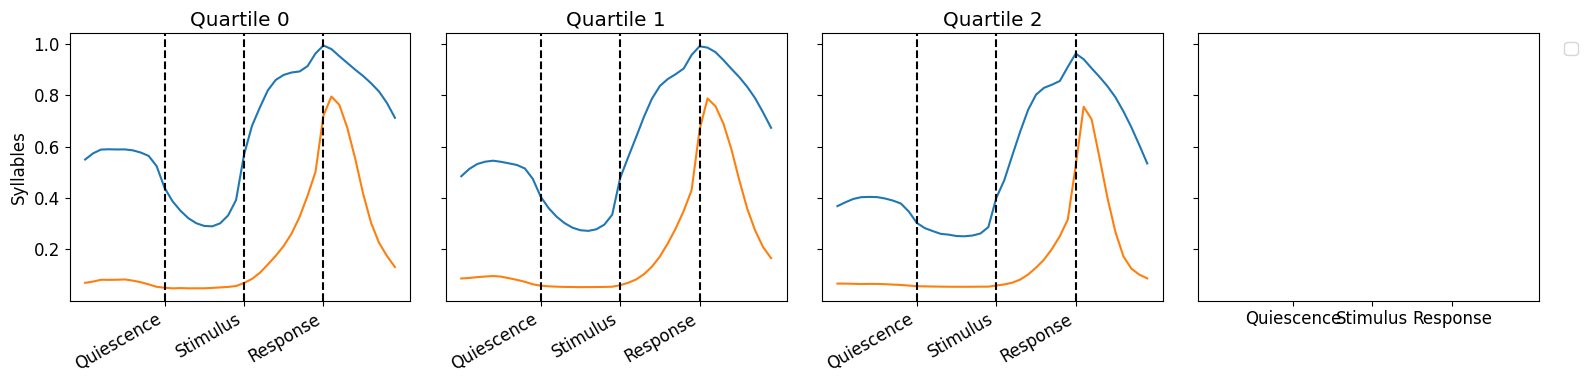

In [218]:
epoch_to_analyse = ['Pre-quiescence', 'Quiescence', 'Choice', 'ITI']

color = sns.color_palette("Set2", 7)
fig, axs = plt.subplots(1, 4, sharex=True, sharey=True, figsize=(16, 4))

use_data = trial_clusters.merge(entropy_df[['mouse_name', 'accuracy_type']].drop_duplicates(), on=['mouse_name'])


for q, quartile in enumerate([0, 1, 2]):
    
    cluster_data = use_data.loc[use_data['accuracy_type']==quartile]
    sequences_choice = np.vstack(cluster_data[epoch_to_analyse].apply(lambda row: np.hstack(row), axis=1))  # Transpose to get the right shape
    use_sequences = sequences_choice[~np.isnan(sequences_choice).any(axis=1)]
    
    replace_whisker = np.vectorize(whisker_mapping.get)
    whisker_states = replace_whisker(use_sequences)
    replace_wheel = np.vectorize(wheel_mapping.get)
    wheel_states = replace_wheel(use_sequences)    
    replace_lick = np.vectorize(lick_mapping.get)
    lick_states = replace_lick(use_sequences)
    
    whisker_count = np.zeros((1, 40))
    lick_count = np.zeros((1, 40))
    wheel_count = np.zeros((4, 40))

    for b, bin in enumerate(range(40)):
        # counts, bins = np.histogram(use_sequences[:, b], range=(0,15), bins=16)
        whisker_count[0, b] = np.sum(whisker_states[:, b]==1)/len(whisker_states[:, b])
        lick_count[0, b] = np.sum(lick_states[:, b]==1)/len(lick_states[:, b])
        wheel_count[0, b] = np.sum(wheel_states[:, b]==1)/len(wheel_states[:, b])
        wheel_count[1, b] = np.sum(wheel_states[:, b]==2)/len(wheel_states[:, b])
        wheel_count[2, b] = np.sum(wheel_states[:, b]==3)/len(wheel_states[:, b])
        wheel_count[3, b] = np.sum(wheel_states[:, b]==0)/len(wheel_states[:, b])
    
    all_stacked = np.vstack([wheel_count, whisker_count, lick_count])
    # all_stacked = np.vstack([wheel_count])

    # cmap_value_1 = create_shaded_cmap(colors[q], name='cmap_value_1')
    # image = axs[c].imshow(all_stacked, cmap=cmap_value_1, aspect='auto')
    axs[q].plot(all_stacked[4:6, :].T, label=['Whisking', 'Licking'])
    # image = axs[q].imshow(all_stacked, cmap='Greys', aspect='auto')
    # fig.colorbar(image, ax=axs[q], location='right', anchor=(0, 0.3))
    # axs[q].set_yticks(np.arange(0, 6, 1), ['Wheel 0', 'Wheel 1', 'Wheel 2', 'Wheel 3', 'Whisking', 'Licking'])
    # axs[c].set_yticks(np.arange(0, 4, 1), ['Wheel 0', 'Wheel 1', 'Wheel 2', 'Wheel 3'])
    axs[q].axvline(x=10, color='k', linestyle='--')
    axs[q].axvline(x=20, color='k', linestyle='--')
    axs[q].axvline(x=30, color='k', linestyle='--')

    axs[q].set_xticks(np.arange(10, 31, 10), ['Quiescence', 'Stimulus', 'Response'], rotation=30, ha='right')
    # axs[c].set_xlabel('Time in epoch')
    axs[q].set_title('Quartile ' +str(quartile))
plt.legend(bbox_to_anchor=(1.05, 1.0), loc='upper left')
axs[0].set_ylabel('Syllables')
plt.tight_layout()
plt.show()